In [4]:
'''This code is the Jupyter notebook version within this folder. 
The primary purpose of this file is to demonstrate the feasibility of t-SNE plots 
and 5-bit gradient quantization.'''
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torchvision.transforms.functional as TF
from torch.ao.quantization import QuantStub, DeQuantStub, prepare_qat, prepare,convert,QConfig,get_default_qat_qconfig,default_observer
from torch.ao.quantization.observer import MinMaxObserver
import time
import json
import wandb
import random
import argparse
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
image_size=14

In [6]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual)
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

resnet18 = ResNet18()


In [ ]:

trainset = torchvision.datasets.MNIST(root="..//data//",
                            transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize((image_size,image_size)), torchvision.transforms.ToTensor()]
    ),
                            train=True,
                            download=True)
testset = torchvision.datasets.MNIST(root="..//data//",
                           transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize((image_size,image_size)), torchvision.transforms.ToTensor()]
    ),
                           train=False,
                           download=True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, 
    shuffle=False)

teacher_model = ResNet18()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher_model.parameters(), lr=0.005, momentum=0.9)
num_epochs = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
teacher_model.to(device)


In [8]:
import numpy as np

train_data = []
train_labels = []
for images, labels in trainloader:
    train_data.append(images.view(images.size(0), -1).numpy())
    train_labels.append(labels.numpy())

test_data = []
test_labels = []
for images, labels in testloader:
    test_data.append(images.view(images.size(0), -1).numpy())
    test_labels.append(labels.numpy())

train_data = np.concatenate(train_data, axis=0)
train_labels = np.concatenate(train_labels, axis=0)
test_data = np.concatenate(test_data, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

In [9]:
tsne = TSNE(n_components=2, random_state=42)
test_data_tsne = tsne.fit_transform(test_data)

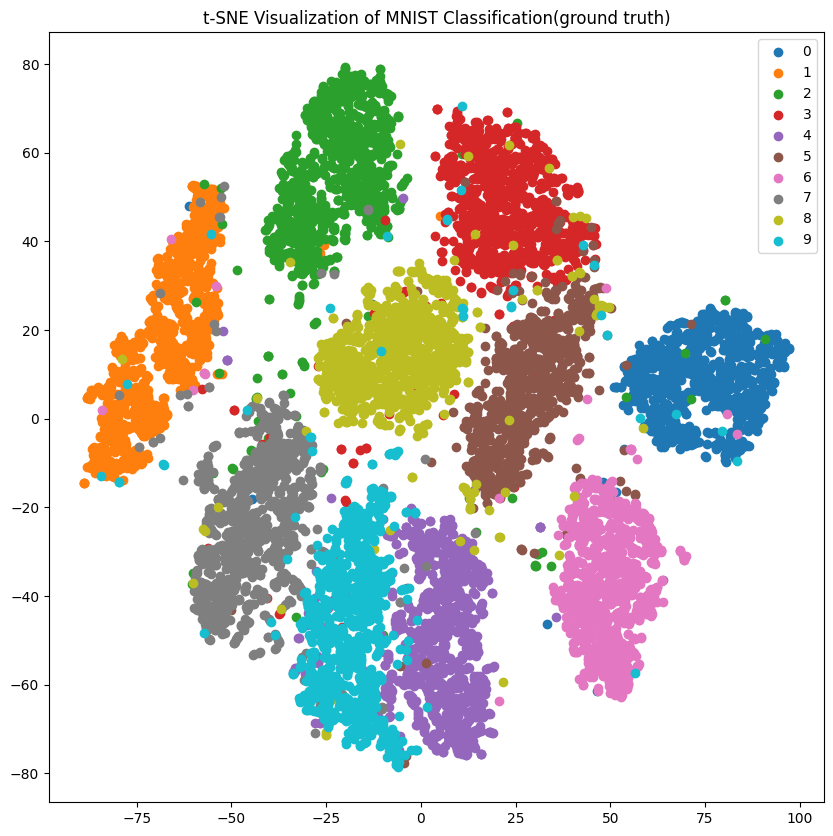

In [10]:
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.scatter(test_data_tsne[test_labels == i, 0], test_data_tsne[test_labels == i, 1], label=str(i))
plt.legend()
plt.title('t-SNE Visualization of MNIST Classification(ground truth)')
plt.show()

In [11]:
def train_teacher(model,num_epochs,trainloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 600 == 599:  
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 600))
                running_loss = 0.0
    print('Training finished.')
def train(model,epochs,trainloader):
    cost = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    for epoch in range(epochs):
        sum_loss = 0
        train_correct = 0
        for data in trainloader:
            inputs, labels = data 
            inputs = torch.flatten(inputs, start_dim=1).to(device)
            inputs =(inputs > 0.25).float()
            outputs = model(inputs).to(device)
            optimizer.zero_grad()
            labels=labels.to(device)
            loss = cost(outputs, labels )
            loss.backward()
            optimizer.step()
            _, id = torch.max(outputs.data, 1)
            sum_loss += loss.data
            train_correct += torch.sum(id == labels.data)
        if epoch > 5:
            model.apply(torch.ao.quantization.disable_observer)
        if epoch > 3:
            model.apply(torch.nn.intrinsic.qat.freeze_bn_stats)
        print('[%d/%d] loss:%.3f, correct:%.3f%%' %
              (epoch + 1, epochs, sum_loss / len(trainloader),
               100 * train_correct / len(trainloader)/64,))
    model.eval()

In [14]:
train_teacher(teacher_model,10,trainloader) 

[1,   600] loss: 0.151
[2,   600] loss: 0.040
[3,   600] loss: 0.027
[4,   600] loss: 0.017
[5,   600] loss: 0.014
[6,   600] loss: 0.009
[7,   600] loss: 0.008
[8,   600] loss: 0.006
[9,   600] loss: 0.004
[10,   600] loss: 0.004
Training finished.


In [15]:
def test(model,testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = (inputs > 0.25).float()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy on the test set: %.2f %%' % (100 * correct / total))
def test_student(model,testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader, 0):
        #for data in testloader:
            device=torch.device('cuda:0')
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = torch.flatten(inputs, start_dim=1).to(device)
            inputs = (inputs > 0.25).float()
            outputs = model(inputs.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy on the test set: %.2f %%' % (100 * correct / total))
    return 100 *correct / total

In [16]:
test(teacher_model,testloader)

Accuracy on the test set: 94.17 %


In [17]:
num_i = image_size * image_size  
num_h =14
num_o = 10  
batch_size = 64

class MLP(torch.nn.Module):

    def __init__(self, num_i, num_h, num_o):
        super(MLP, self).__init__()
        self.quant = QuantStub()
        self.linear1 = torch.nn.Linear(num_i, num_h)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(num_h, num_h) 
        self.relu2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(num_h, num_h) 
        self.relu3 = torch.nn.ReLU()
        self.linear4 = torch.nn.Linear(num_h, num_o)
        self.dequant = DeQuantStub()

    
    def forward(self, x):
        x = self.quant(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x) 
        x = self.relu2(x)
        x = self.linear3(x) 
        x = self.relu(x)
        x = self.linear4(x)
        x = self.dequant(x)
        return x
    
def get_default_qat_qconfig_per_tensor(backend='fbgemm'):
    activation = default_observer.with_args(reduce_range=False,quant_min=-16,quant_max=15)
    weight = default_observer.with_args(dtype=torch.qint8, reduce_range=False,quant_min=-16,quant_max=15)
    return QConfig(activation=activation, weight=weight)

student_model = MLP(num_i, num_h, num_o).to(device)
student_model.qconfig = get_default_qat_qconfig_per_tensor()
model_qat = prepare_qat(student_model)
criterion = nn.CrossEntropyLoss()

In [18]:
train(model_qat,20,trainloader)

[1/20] loss:0.914, correct:71.154%
[2/20] loss:0.439, correct:86.650%
[3/20] loss:0.372, correct:88.536%
[4/20] loss:0.338, correct:89.526%
[5/20] loss:0.313, correct:90.304%
[6/20] loss:0.288, correct:91.036%
[7/20] loss:0.268, correct:91.698%
[8/20] loss:0.255, correct:92.094%
[9/20] loss:0.245, correct:92.401%
[10/20] loss:0.238, correct:92.667%
[11/20] loss:0.232, correct:92.777%
[12/20] loss:0.227, correct:93.060%
[13/20] loss:0.222, correct:93.159%
[14/20] loss:0.219, correct:93.270%
[15/20] loss:0.216, correct:93.367%
[16/20] loss:0.211, correct:93.452%
[17/20] loss:0.210, correct:93.470%
[18/20] loss:0.207, correct:93.538%
[19/20] loss:0.204, correct:93.647%
[20/20] loss:0.201, correct:93.732%


In [19]:
test_accuracy_light_ce_and_kd = test_student(model_qat, testloader)

Accuracy on the test set: 93.40 %


In [20]:
model_quantized = convert(model_qat.eval(), inplace=False)

In [21]:
def train_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, T, soft_target_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Forward pass with the student model
            student_logits = student(torch.flatten(inputs, start_dim=1).to(device))

            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = -torch.sum(soft_targets * soft_prob) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")



In [22]:
model_qat.train()
train_knowledge_distillation(teacher=teacher_model, student=model_qat, train_loader=trainloader, epochs=10, learning_rate=0.005, T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device=device)

Epoch 1/10, Loss: 0.5158678044292972
Epoch 2/10, Loss: 0.4748601012710315
Epoch 3/10, Loss: 0.46184360296296667
Epoch 4/10, Loss: 0.44765306456383863
Epoch 5/10, Loss: 0.43943416111187134
Epoch 6/10, Loss: 0.4266446778642089
Epoch 7/10, Loss: 0.4244431598481339
Epoch 8/10, Loss: 0.42026355325667336
Epoch 9/10, Loss: 0.4125957482023788
Epoch 10/10, Loss: 0.4083137584329922


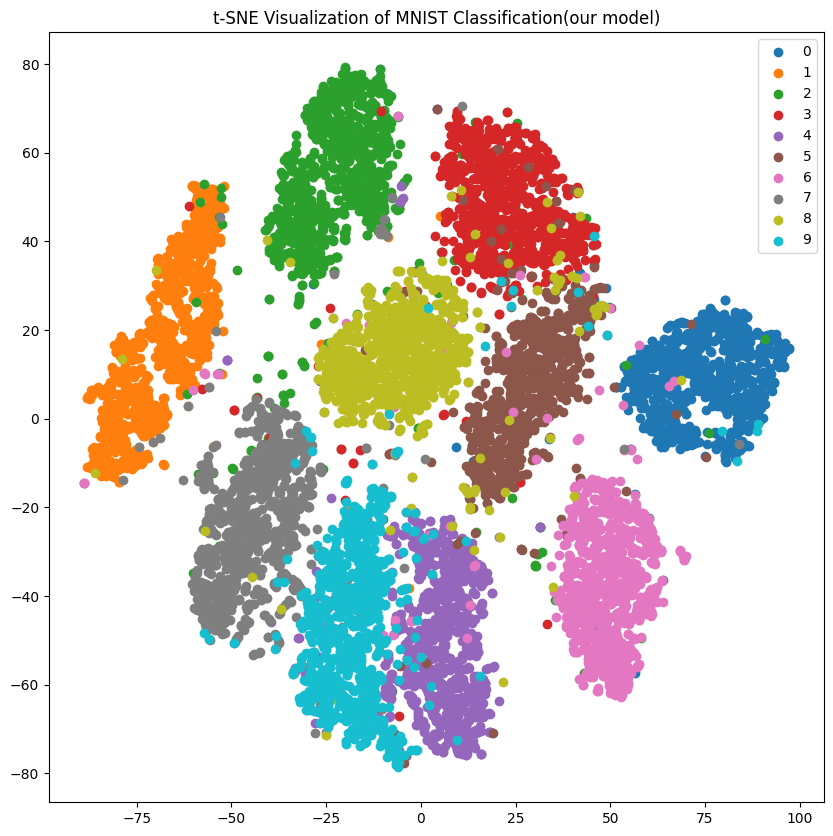

In [23]:
model_qat.eval()
y_pred= []
tsne = TSNE(n_components=2, random_state=42)
test_data_tsne = tsne.fit_transform(test_data)
for images, labels in testloader:
    images = torch.flatten(images, start_dim=1).to(device)
    outputs=model_qat(images)
    _, id = torch.max(outputs.data, 1)
    y_pred.extend(id.to("cpu").numpy().tolist())
y_pred =np.array(y_pred)
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.scatter(test_data_tsne[y_pred == i, 0], test_data_tsne[y_pred == i, 1], label=str(i))

plt.legend()
plt.title('t-SNE Visualization of MNIST Classification(our model)')
plt.show()

In [24]:
model_qat.eval()
test_accuracy_light_ce_and_kd = test_student(model_qat, testloader)

print(test_accuracy_light_ce_and_kd)

Accuracy on the test set: 91.15 %
91.15


In [25]:
'''The purpose of this code is to verify the 
feasibility of 5-bit gradient quantization. 
If it needs to be used in the complete code,
please replace this part of the code with the 
class in the MLP.py file and remove the quantization
stub of the train_student function in train.py.'''
NUM_BITS = 5
NUM_BITS_WEIGHT = 5
NUM_BITS_GRAD = 5
num_i = image_size * image_size 
num_h =14
num_o = 10  
batch_size = 64
from quantized_pytorch_master.models.modules.quantize import quantize, quantize_grad, QConv2d, QLinear, RangeBN
class MLP(torch.nn.Module):

    def __init__(self, num_i, num_h, num_o):
        super(MLP, self).__init__()
        self.quant = QuantStub()
        self.linear1 = QLinear(num_i,num_h, num_bits=NUM_BITS, num_bits_weight=NUM_BITS_WEIGHT, num_bits_grad=NUM_BITS_GRAD)
        self.relu = torch.nn.ReLU()
        self.linear2 =  QLinear(num_h,num_h, num_bits=NUM_BITS, num_bits_weight=NUM_BITS_WEIGHT, num_bits_grad=NUM_BITS_GRAD)  
        self.relu2 = torch.nn.ReLU()
        self.linear3 = QLinear(num_h,num_h, num_bits=NUM_BITS, num_bits_weight=NUM_BITS_WEIGHT, num_bits_grad=NUM_BITS_GRAD)  
        self.relu3 = torch.nn.ReLU()
        self.linear4 =  QLinear(num_h,num_o, num_bits=NUM_BITS, num_bits_weight=NUM_BITS_WEIGHT, num_bits_grad=NUM_BITS_GRAD)
        self.dequant = DeQuantStub()

    
    def forward(self, x):
        x = self.quant(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x) 
        x = self.relu2(x)
        x = self.linear3(x) 
        x = self.relu(x)
        x = self.linear4(x)
        x = self.dequant(x)
        return x
    
def get_default_qat_qconfig_per_tensor(backend='fbgemm'):
    activation = default_observer.with_args(reduce_range=False,quant_min=-16,quant_max=15)
    weight = default_observer.with_args(dtype=torch.qint8, reduce_range=False,quant_min=-16,quant_max=15)
    return QConfig(activation=activation, weight=weight)

student_model = MLP(num_i, num_h, num_o).to(device)
student_model.qconfig = get_default_qat_qconfig_per_tensor()
model_qat = prepare_qat(student_model)
criterion = nn.CrossEntropyLoss()

In [26]:
train(model_qat,10,trainloader)

[1/10] loss:0.965, correct:68.284%
[2/10] loss:0.472, correct:85.593%
[3/10] loss:0.394, correct:88.046%
[4/10] loss:0.356, correct:89.112%
[5/10] loss:0.333, correct:89.782%
[6/10] loss:0.315, correct:90.380%
[7/10] loss:0.307, correct:90.548%
[8/10] loss:0.294, correct:90.913%
[9/10] loss:0.286, correct:91.143%
[10/10] loss:0.284, correct:91.221%


In [27]:
test_accuracy_light_ce_and_kd = test_student(model_qat, testloader)

Accuracy on the test set: 91.30 %


In [21]:
quantized_model = convert(model_qat, inplace=False)
torch.save(quantized_model.state_dict(),'./student_model.pth')